In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from plot_params import * 
from scipy.stats import normaltest

In [275]:
def task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request() as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))
        
def short_task(env, server, processing_time, waiting_time):
    """task arrives, is served and leaves."""
    arrive = env.now
    with server.request(priority=processing_time) as req:
        yield req
        waiting_time.append(env.now-arrive)
        #print('Task %s arrived at: %7.4f: ' % (arrive))
        yield env.timeout(processing_time)
        #print('Task %s finished at %s' % (env.now))
        
def batch_mean(x, batch_size):
    x_mean = np.reshape(x,(batch_size,int(len(x)/batch_size)))
    x_mean = np.mean(x_mean, axis=0)
    return x_mean

def batch_var(x, batch_size, n_batches, n_samples):
    mean_x = np.mean(x)
    batch_var = batch_size/(n_samples*(n_batches-1))*np.square(x - mean_x).sum()
    return batch_var

def deterministic(x):
    return 1/x

def longtail(x):
    mu_big = 1
    mu_small = 0.75*x*mu_big/(mu_big-0.25*x)
    a = random.random()
    if a < 0.25:
        n = random.expovariate(mu_big)
    else:
        n = random.expovariate(mu_small)
    return n

In [276]:
class Setup_samples(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, n_samples, p_distribution):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.n_samples_reached = env.event()
        self.n_samples = n_samples
        self.p_distribution = p_distribution
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>self.n_samples:
                self.n_samples_reached.succeed()
                self.n_samples_reached = self.env.event()
            
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)
            processing_time = self.p_distribution(self.processing_capacity)
            env.process(task(self.env, self.server, processing_time, waiting_times))

class Setup_shortestjob(object):
    def __init__(self, env, arrival_rate, processing_capacity, server, waiting_times, n_samples, p_distribution):
        self.env = env
        self.arrival_rate = arrival_rate
        self.processing_capacity = processing_capacity
        self.server = server
        self.waiting_times = waiting_times
        self.n_samples_reached = env.event()
        self.n_samples = n_samples
        self.p_distribution = p_distribution
        self.action = env.process(self.run())
    
    def run(self):
        while True:
            if  len(self.waiting_times)>self.n_samples:
                self.n_samples_reached.succeed()
                self.n_samples_reached = self.env.event()
            
            arrival_time = random.expovariate(self.arrival_rate)
            yield env.timeout(arrival_time)
            processing_time = self.p_distribution(self.processing_capacity)
            env.process(short_task(self.env, self.server, processing_time, waiting_times))

In [290]:
#global variables
n_steps = 10
n_servers = np.array([1, 2, 4])
arrival_rate = n_servers
init_util = 0.5
final_util = 0.9
server_util = np.linspace(init_util, final_util, n_steps)
processing_capacity = 1/server_util
n_samples = 10000
waiting_times_rho_mm = np.zeros((3, n_steps,n_samples))
waiting_times_rho_md = np.zeros((3, n_steps,n_samples))
waiting_times_rho_l = np.zeros((3, n_steps,n_samples))
waiting_times_rho_s = np.zeros((3, n_steps,n_samples))

In [292]:
#for mm/1 and mm/n
for i in range(3):
    for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
        env = simpy.Environment()
        servers1 = simpy.Resource(env, capacity=n_servers[i])
        waiting_times = []
        setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,random.expovariate)
        env.run(until=setup1.n_samples_reached)
        waiting_times_rho_mm[i, j, :] = setup1.waiting_times[:n_samples] 
np.save(f'results/waiting_times_rho_mm', waiting_times_rho_mm)

calculate waiting times for n_server 4: 100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


In [262]:
#for md/1 and md/n
for i in range(3):
    for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
        env = simpy.Environment()
        servers1 = simpy.Resource(env, capacity=n_servers[i])
        waiting_times = []
        setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,deterministic)
        env.run(until=setup1.n_samples_reached)
        waiting_times_rho_md[i, j, :] = setup1.waiting_times[:n_samples]
np.save(f'results/wwaiting_times_rho_md', waiting_times_rho_md)

calculate waiting times for n_server 4: 100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]


In [263]:
#for longtail
for i in range(3):
    for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
        env = simpy.Environment()
        servers1 = simpy.Resource(env, capacity=n_servers[i])
        waiting_times = []
        setup1 = Setup_samples(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,longtail)
        env.run(until=setup1.n_samples_reached)
        waiting_times_rho_l[i, j, :] = setup1.waiting_times[:n_samples]
np.save(f'waiting_times_rho_l', waiting_times_rho_l)

calculate waiting times for n_server 4: 100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.74it/s]


In [277]:
#for shortest job first
for i in range(3):
    for j in tqdm(range(n_steps), desc=f'calculate waiting times for n_server {n_servers[i]}'):
        env = simpy.Environment()
        servers1 = simpy.PriorityResource(env, capacity=n_servers[i])
        waiting_times = []
        setup1 = Setup_shortestjob(env, arrival_rate[i], processing_capacity[j], servers1, waiting_times, n_samples,random.expovariate)
        env.run(until=setup1.n_samples_reached)
        waiting_times_rho_s[i, j, :] = setup1.waiting_times[:n_samples]
np.save(f'waiting_times_rho_s', waiting_times_rho_s)

calculate waiting times for n_server 4: 100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]


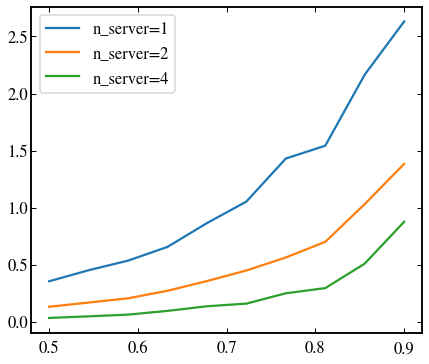

In [289]:
#test if code works

batch_means = np.zeros((3, 50 ,n_steps))
mean_batch = np.zeros((3,n_steps))
for i in range(3):
    for j in range(n_steps):
        batch_means[i,:,j] = batch_mean(waiting_times_rho_s[i, j,:10000], 200)
        mean_batch[i,j] = np.mean(batch_means[i,:,j])
    plt.plot(server_util, mean_batch[i,:], label=f'n_server={n_servers[i]}')  
plt.legend()

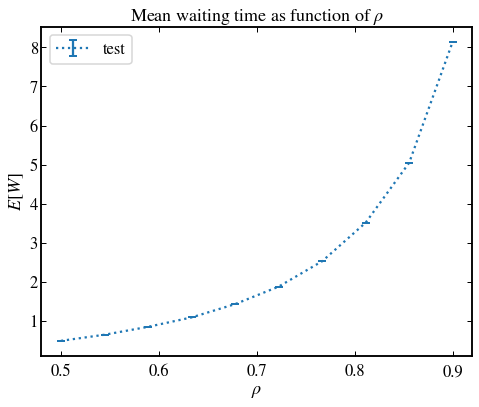

In [107]:
plt.errorbar(
    server_util, 
    mean_waiting_time, var_waiting_time, 
    fmt=':', 
    capsize=4, 
    capthick=2, 
    label='test'
)
plt.fill_between(server_util, mean_waiting_time - var_waiting_time, mean_waiting_time + var_waiting_time, alpha=0.2)
plt.legend()
plt.title(r'Mean waiting time as function of $\rho$')
plt.xlabel(r'$\rho$')
plt.ylabel('$E[W]$')
plt.tight_layout()
#plt.savefig('figures/area_conv_s.pdf')
plt.show()

ValueError: cannot reshape array of size 1000 into shape (2000,0)

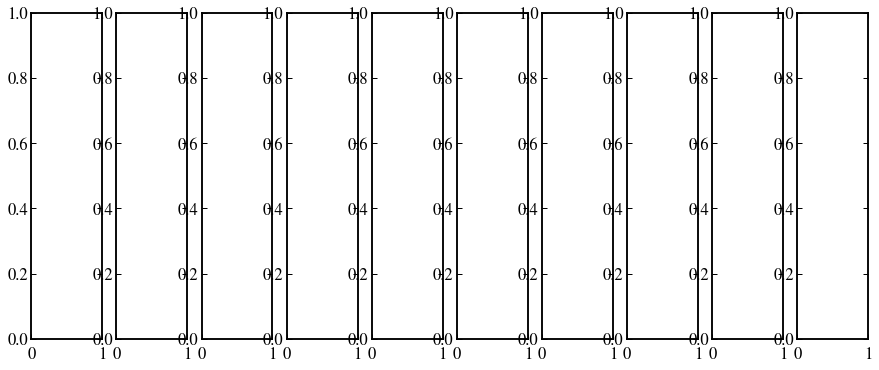

In [116]:
#batch_size = np.linspace(1000,50000, n_steps)
batch_size = np.array([1000, 6000, 10000, 15000, 22800, 28300, 33700, 40000, 45000, 50000,])*2
#batch_size -= batch_size % -100
#batch_size = batch_size * 2 
n_batches = 50
n_samples_normal = batch_size*n_batches
batch_means = np.zeros((n_batches,n_steps))
mean_waiting_time = np.zeros(n_steps)
var_waiting_time = np.zeros(n_steps)
fig, axs = plt.subplots(1, n_steps, figsize=(15, 6))
for ax, i in zip(axs, range(n_steps)):
    batch_means[:,i] = batch_mean(waiting_times_rho[i,:int(n_samples_normal[i])], int(batch_size[i]))
    ax.hist(batch_means[:,i])
    stat, p = normaltest(batch_means[:,i])
    if p > 0.05:
        print(f'{i} is normal distributed with p={p}')
    else:
        print(f'{i} is NOT normal distributed with p={p}')
    mean_waiting_time[i] = np.mean(batch_means[:,i])
    var_waiting_time[i] = batch_var(batch_means[:,i], batch_size[i], n_batches, n_samples_normal[i])
    print(var_waiting_time[i])
    